# Scatter plots with linear regressions.
Create a grid figure where each row and column correspond to a parameter and a season. For each subplot, a linear regression model is fitted to the datapoints. Option to save figures in a CorrelationPlots/ folder.

## Load data

In [ ]:
from METCOMP_utils import *

# Define time interval.
start_date = datetime.date(2019, 1, 1)
end_date = datetime.date(2019, 12, 31)

stations =  ['40013', '40010', '25754', '40003', '24768', '40005', '23470', '25786', '24856', '23658', '40004', '23659', '25652', '20949', '40145', '40007', '40143', '22234']


MESAN_data = {}
LANTMET_data = {}

for station in stations:
    print(f'Loading {station}')
    # Load interpolated data.
    MESAN_data[station] = read_CSV('40010', 'MESAN', start_date, end_date)
    # Load reference observations.
    LANTMET_data[station] = read_CSV('40010', 'LANTMET', start_date, end_date)
    
    # Unit conversion if needed.
    LANTMET_data[station]['UM'] = LANTMET_data[station]['UM']/100.0

## Scatter plots and linear regression.

Working on station 40013
Working on station 40010
Working on station 25754
Working on station 40003
Working on station 24768
Working on station 40005
Working on station 23470
Working on station 25786
Working on station 24856
Working on station 23658
Working on station 40004
Working on station 23659
Working on station 25652
Working on station 20949
Working on station 40145
Working on station 40007
Working on station 40143
Working on station 22234


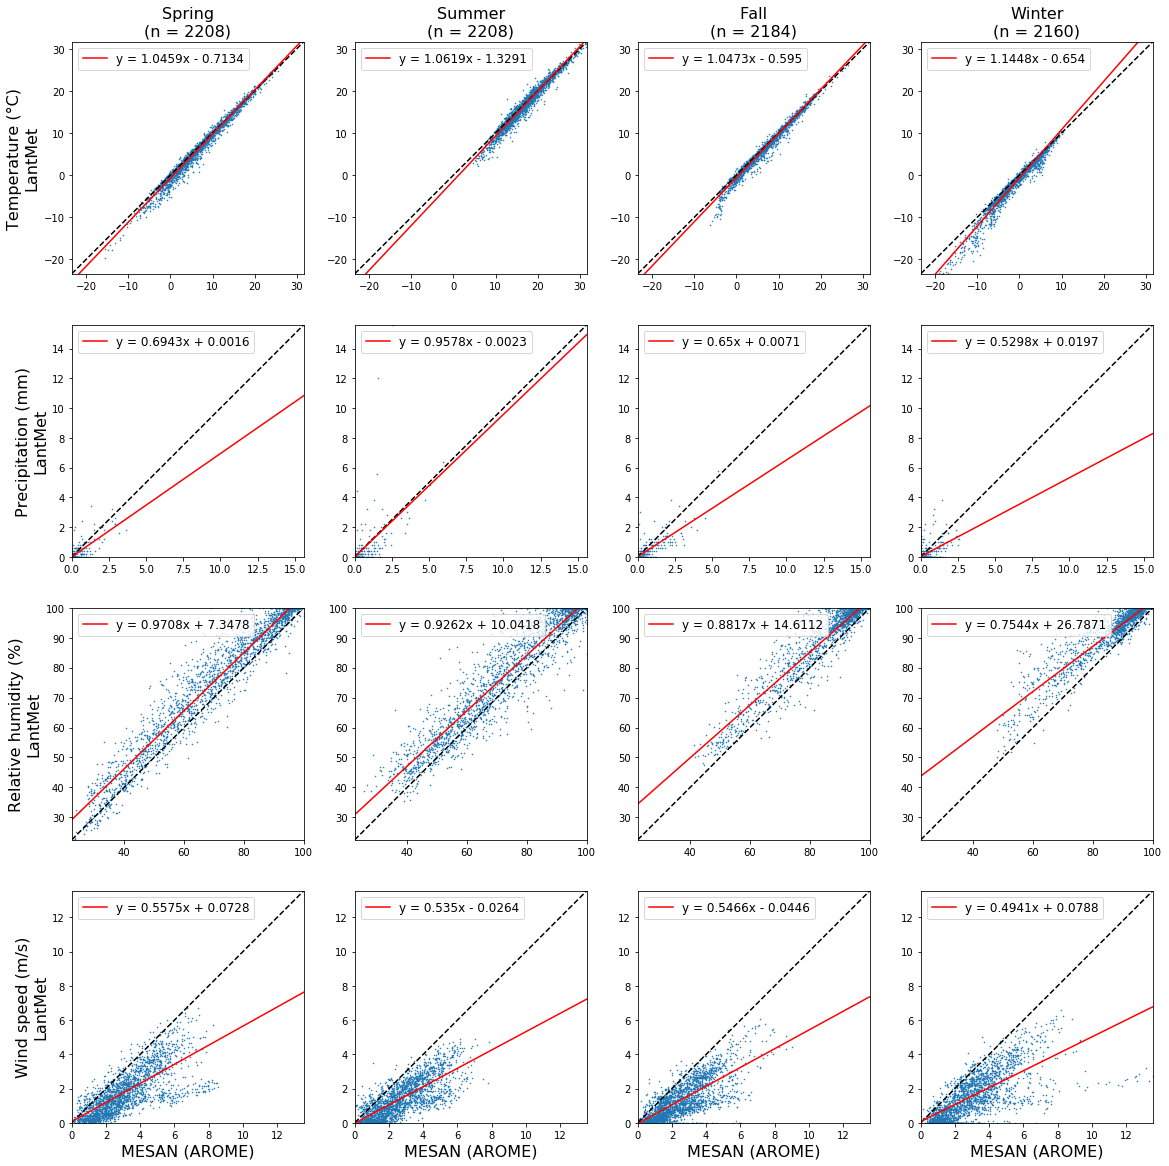

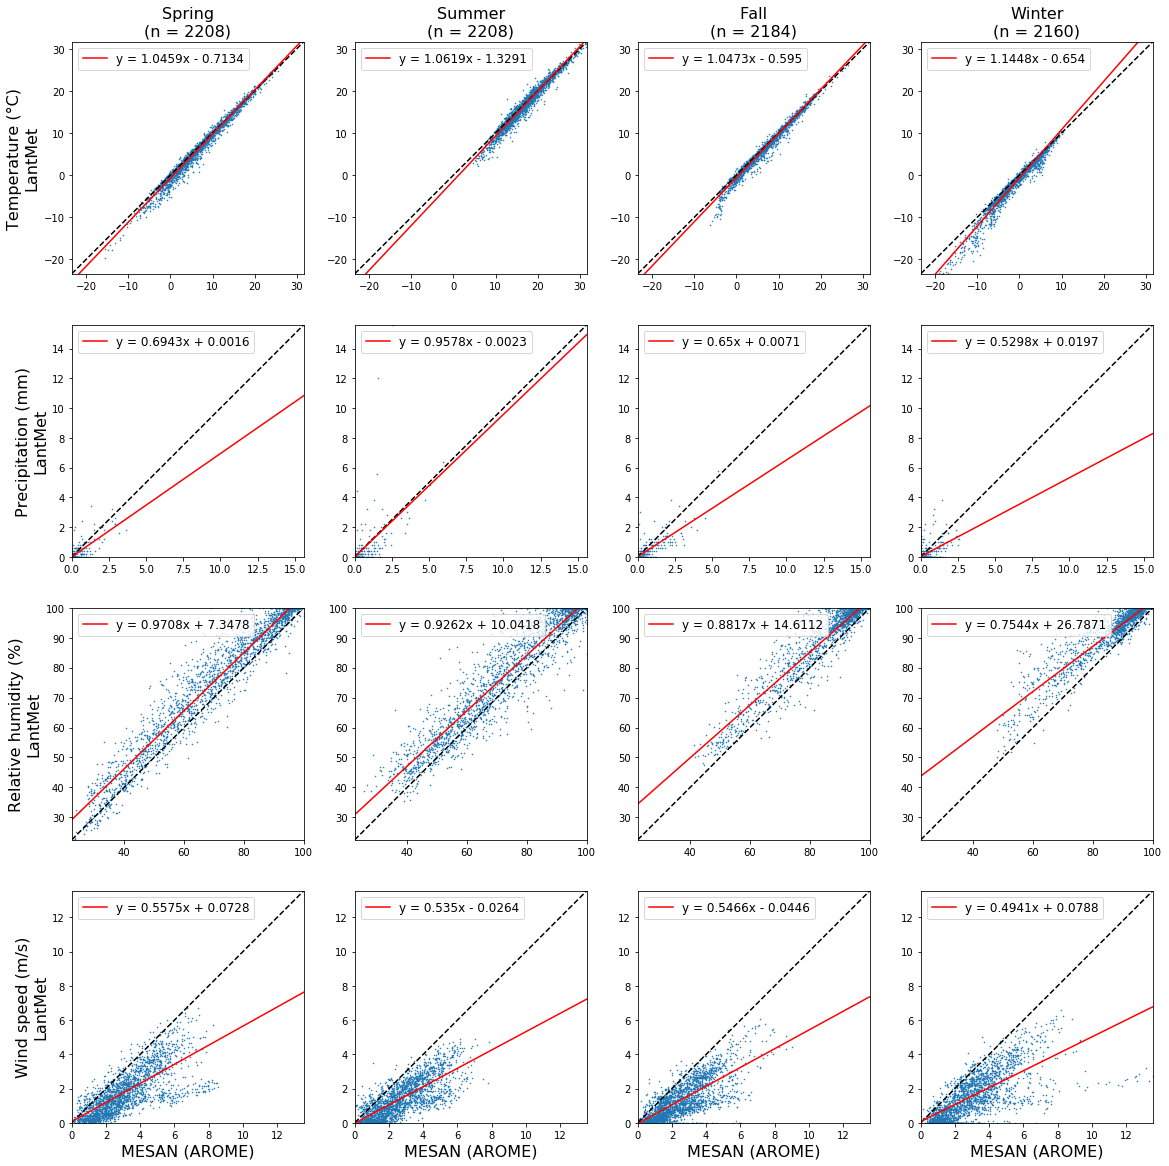

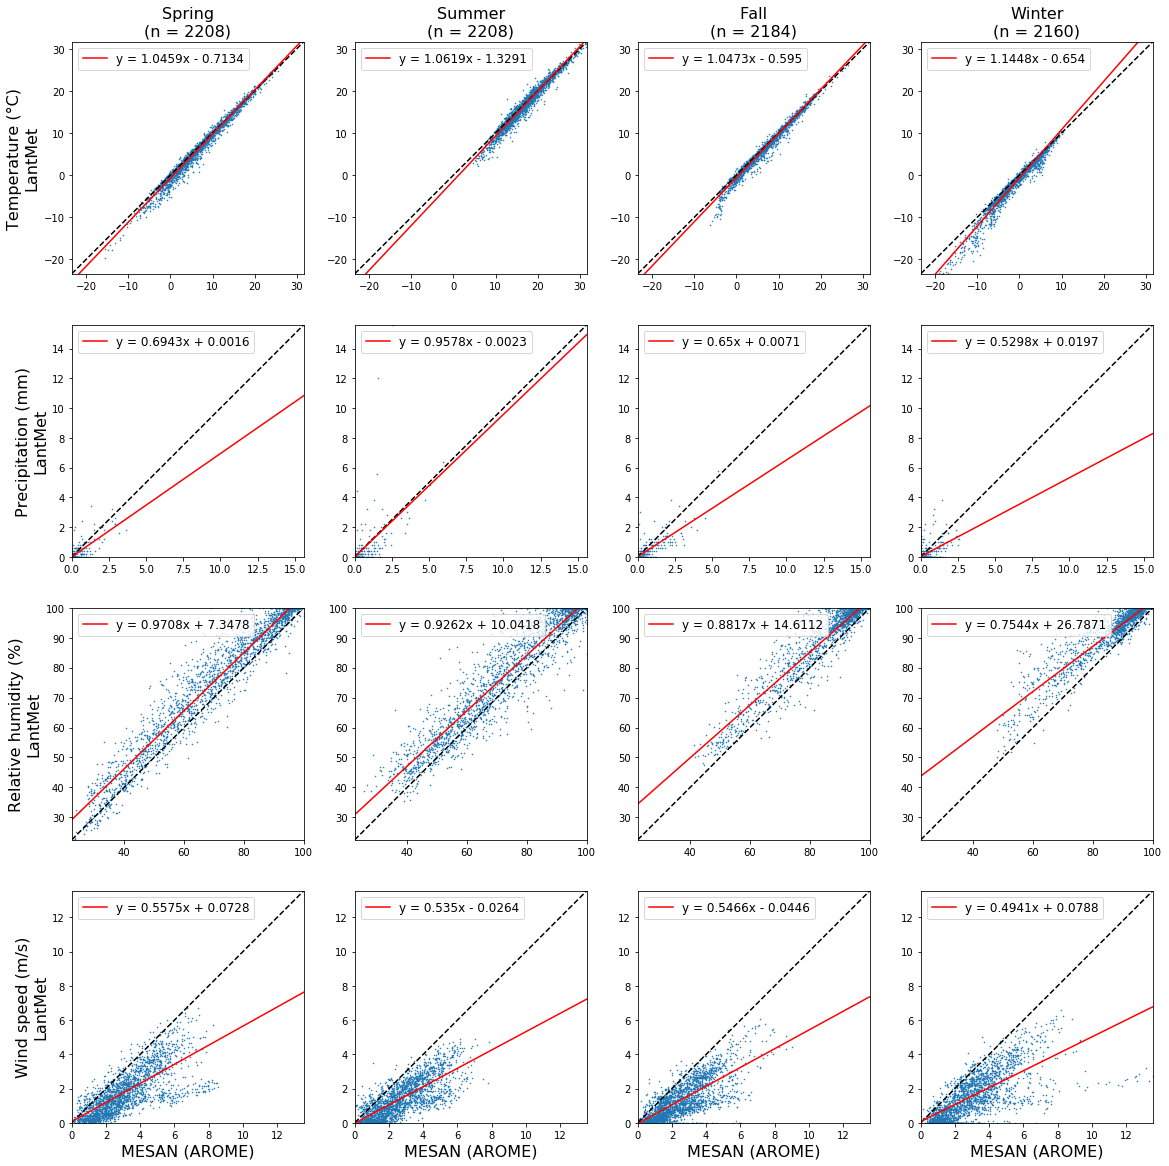

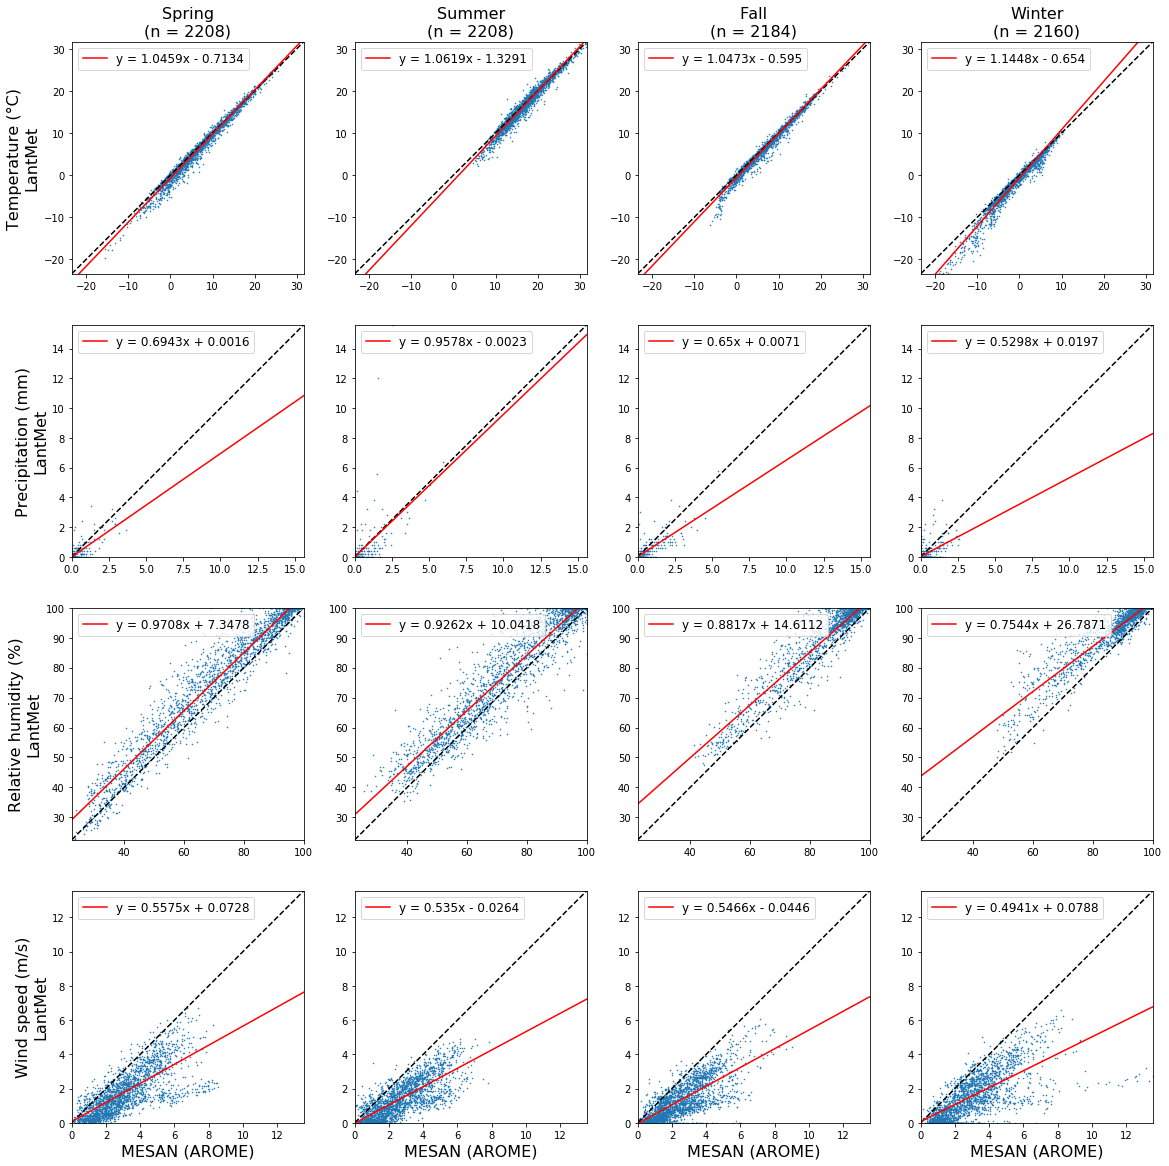

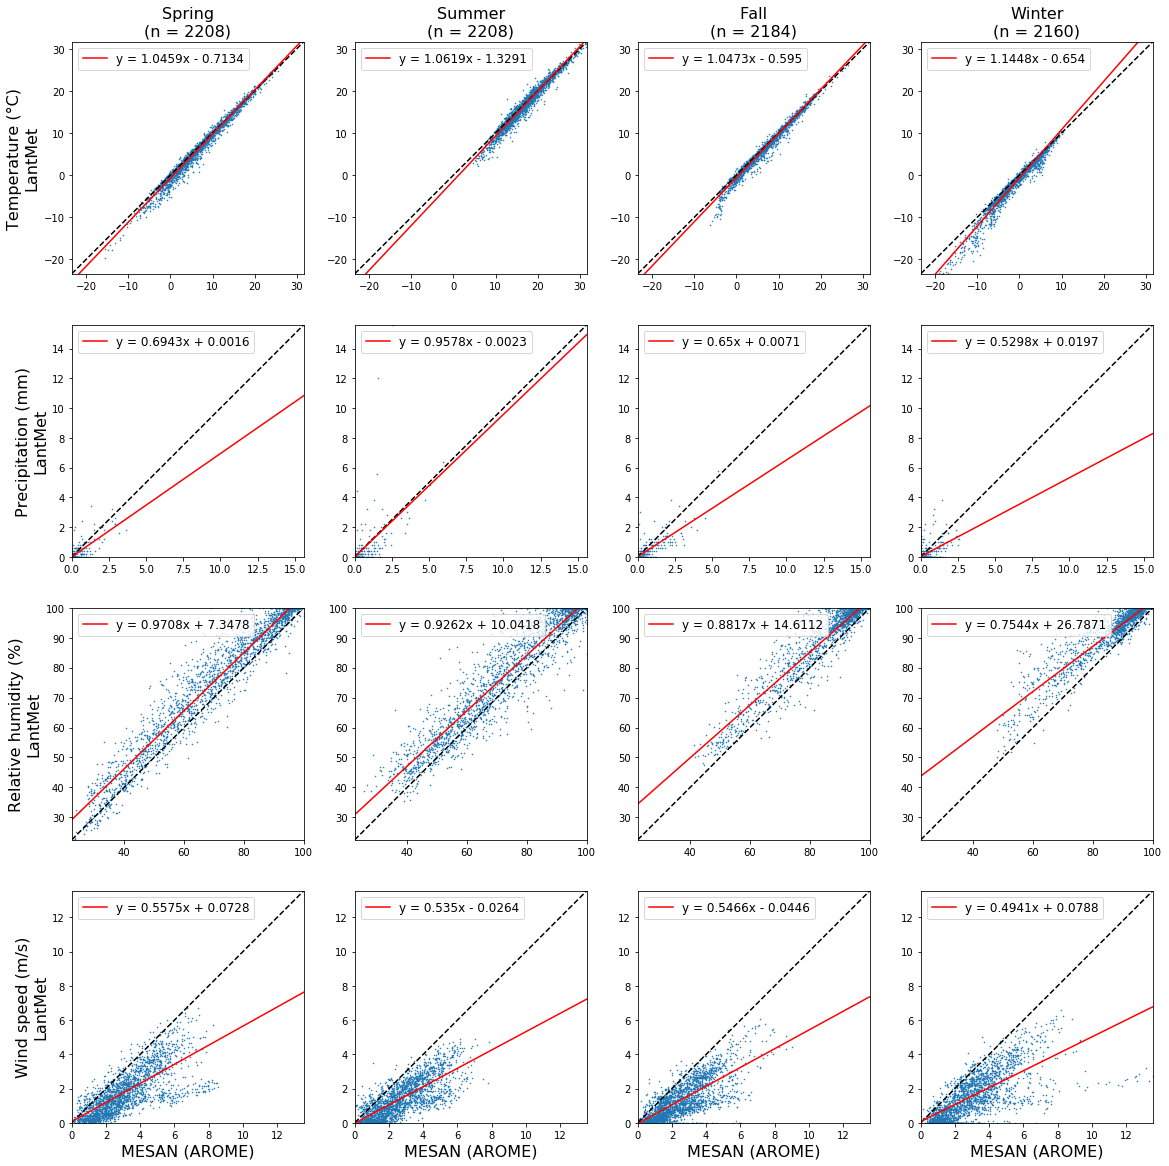

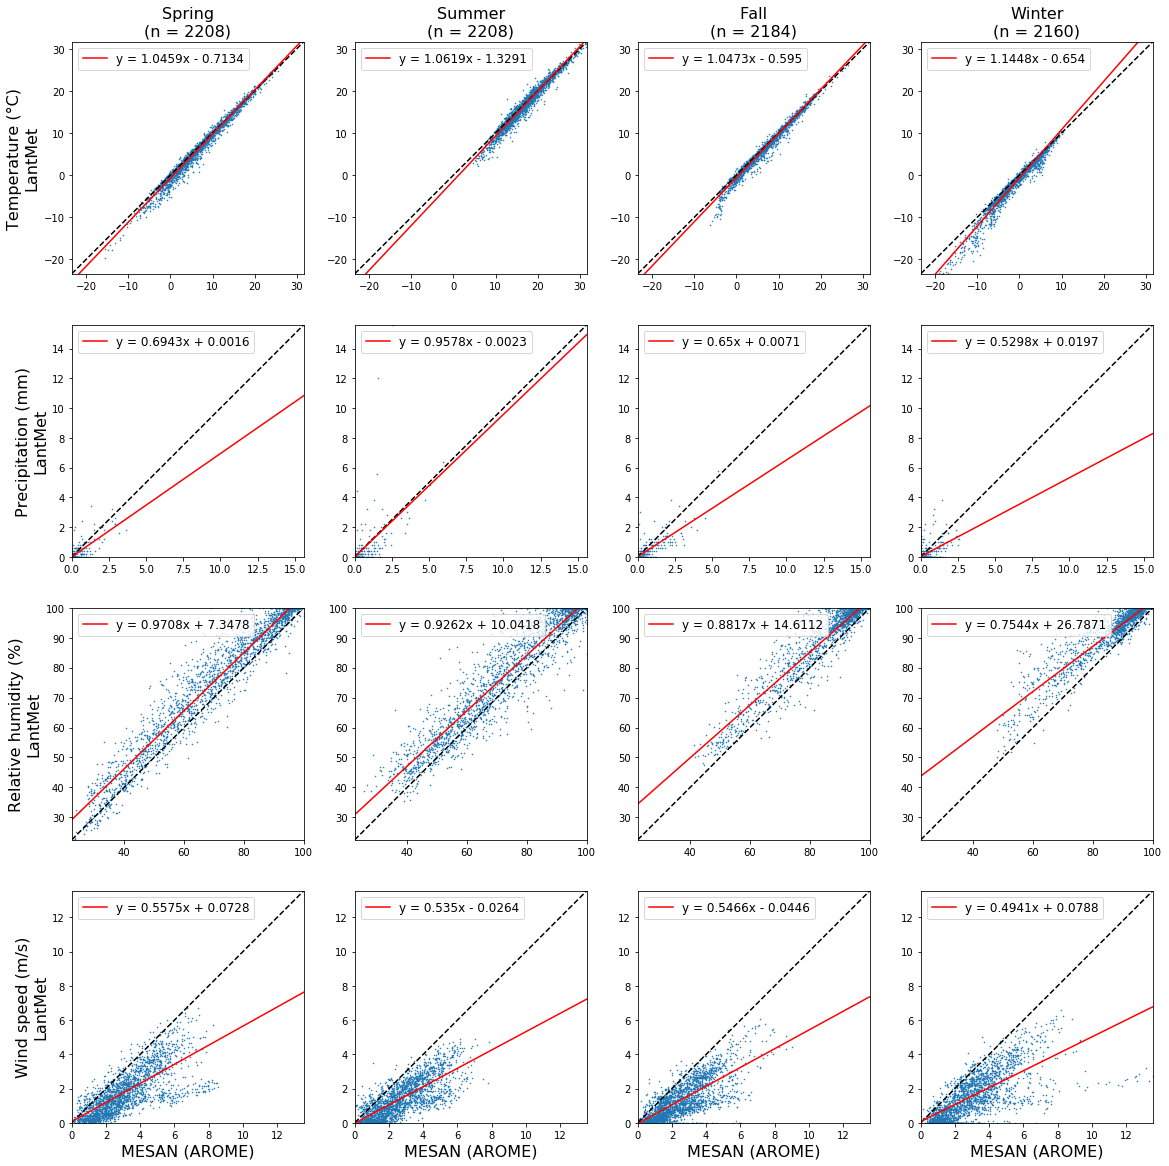

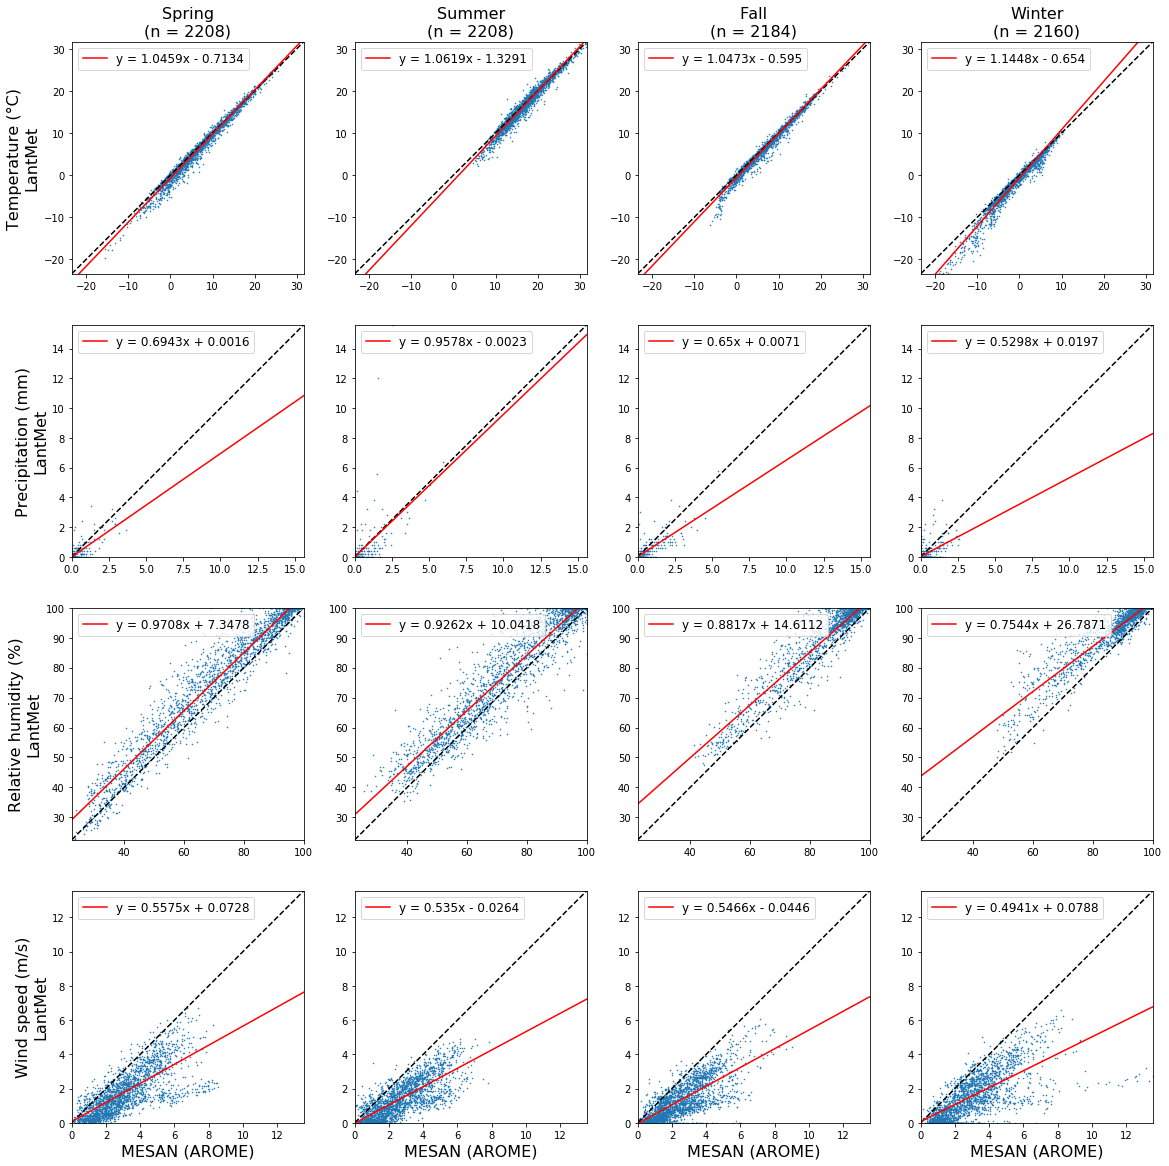

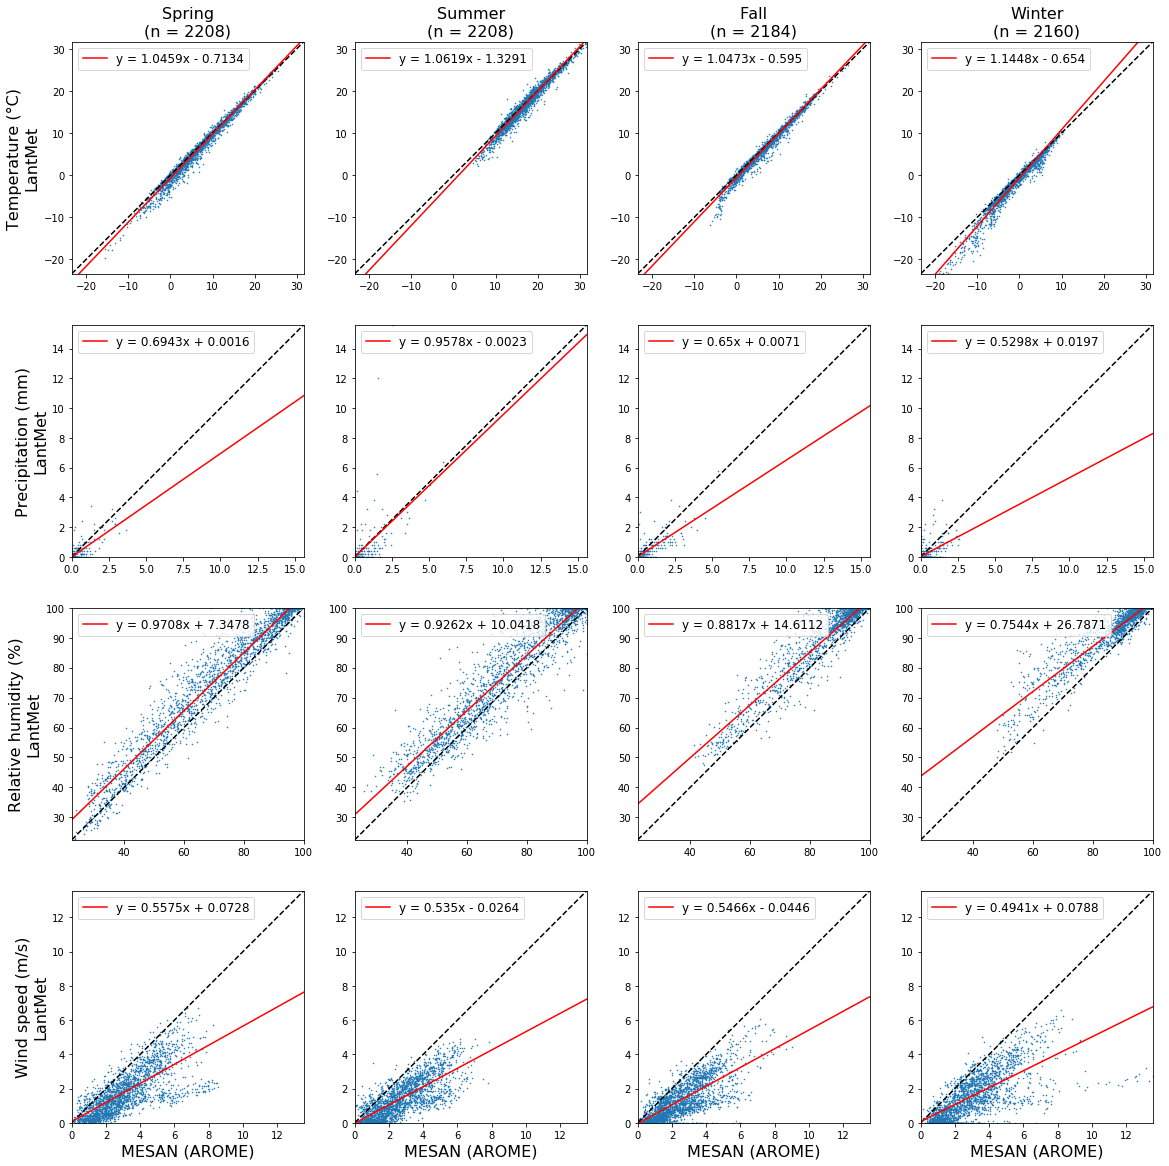

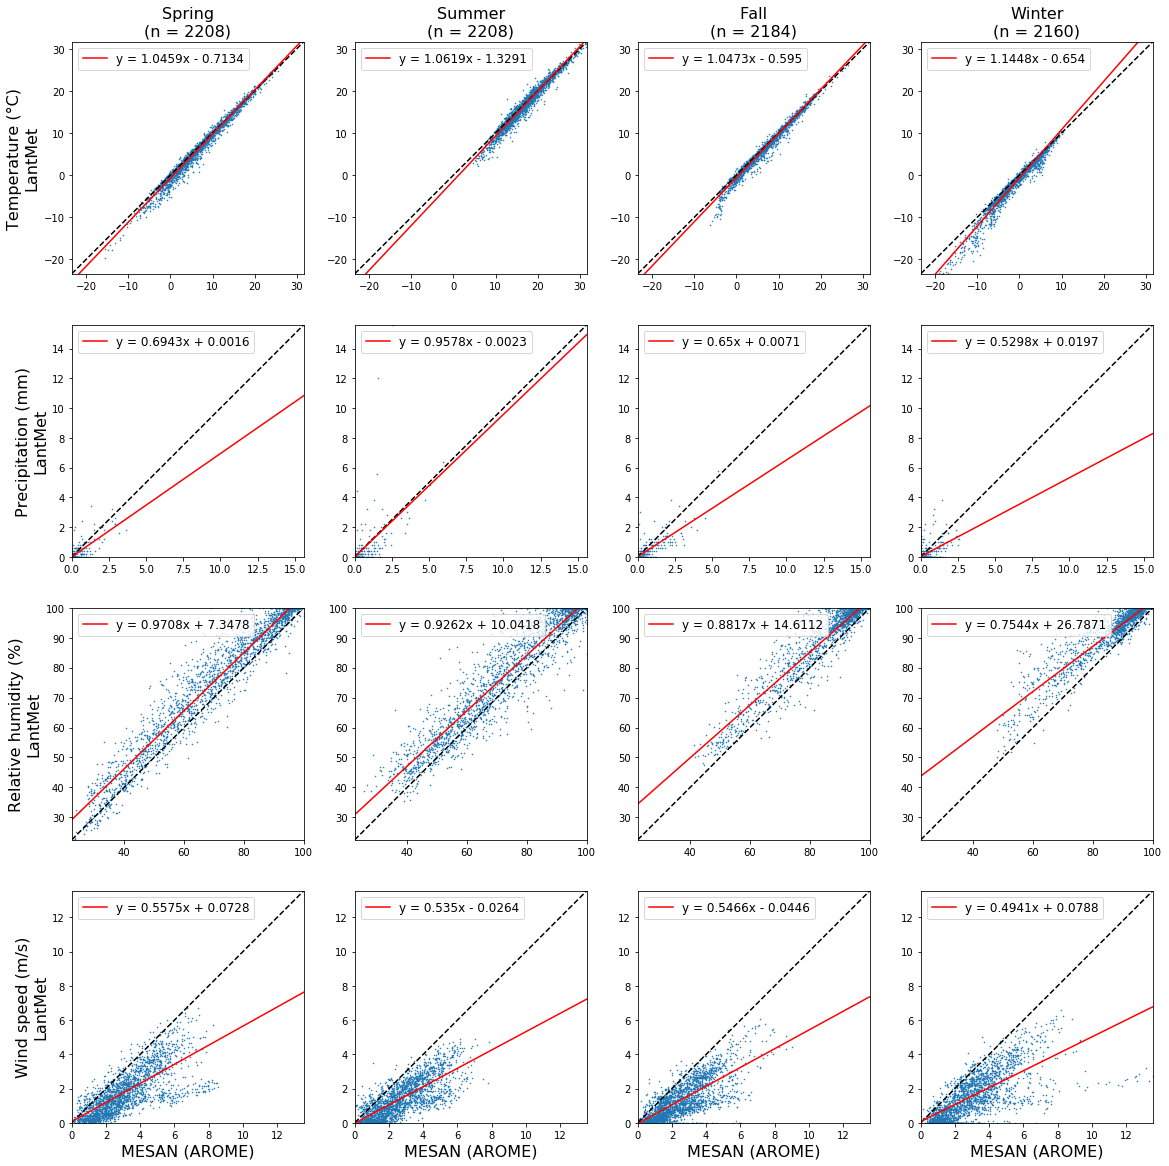

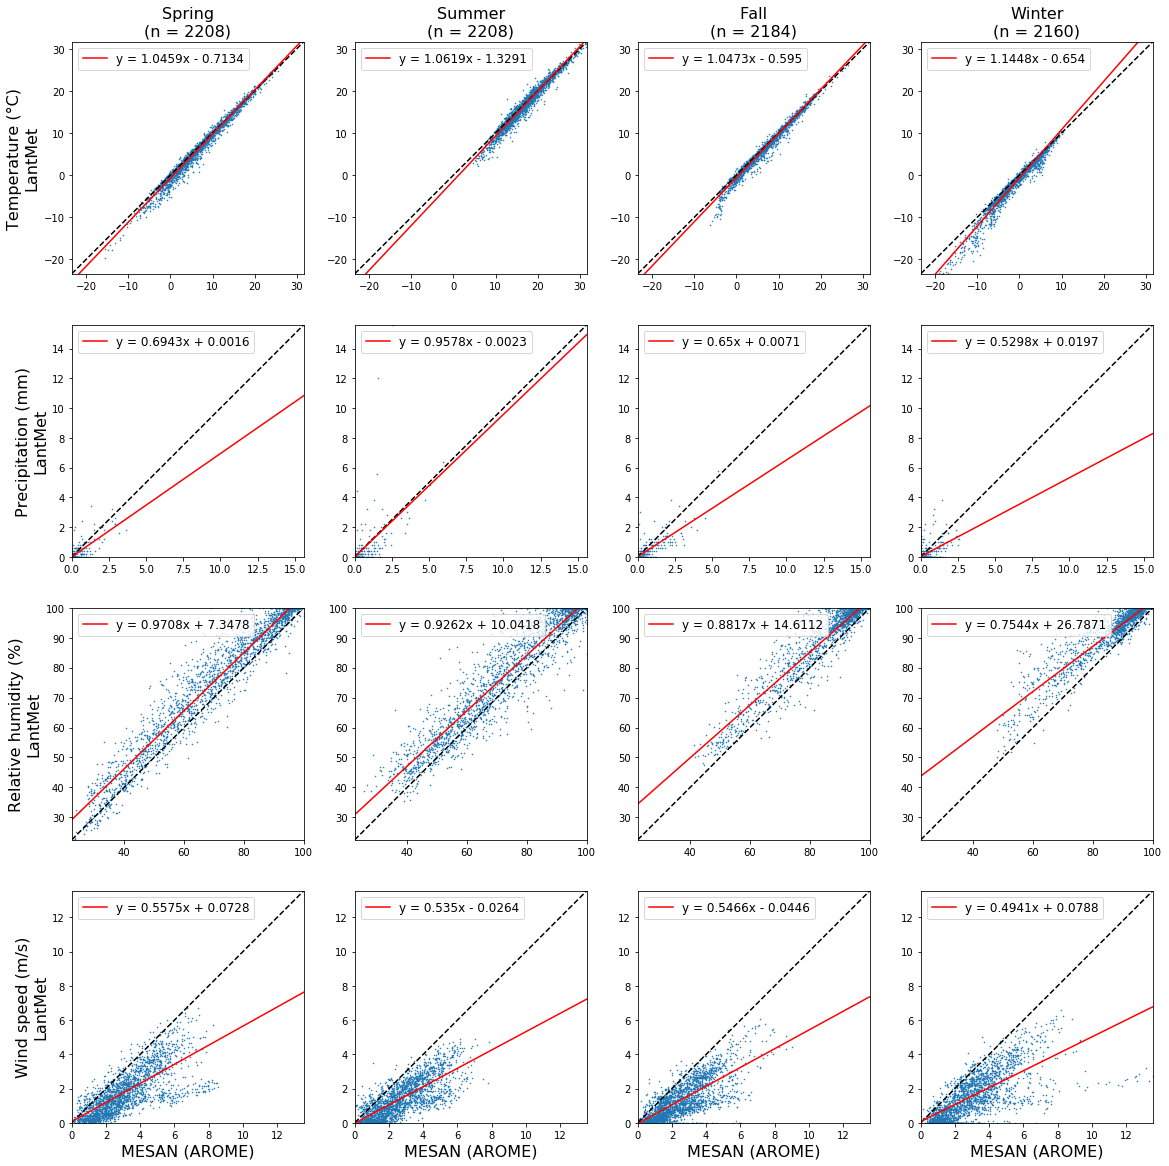

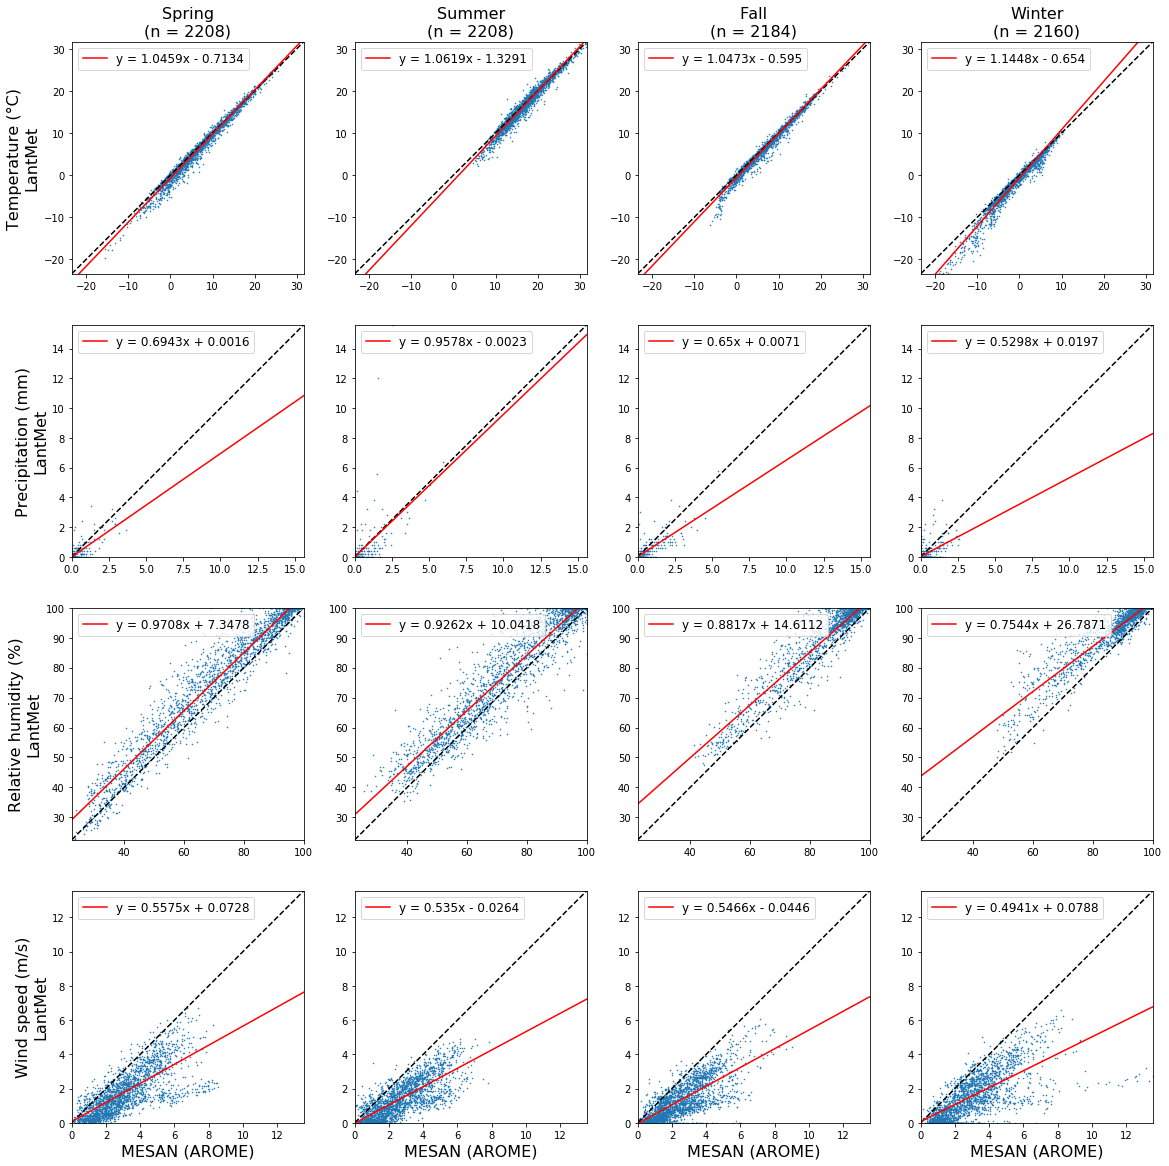

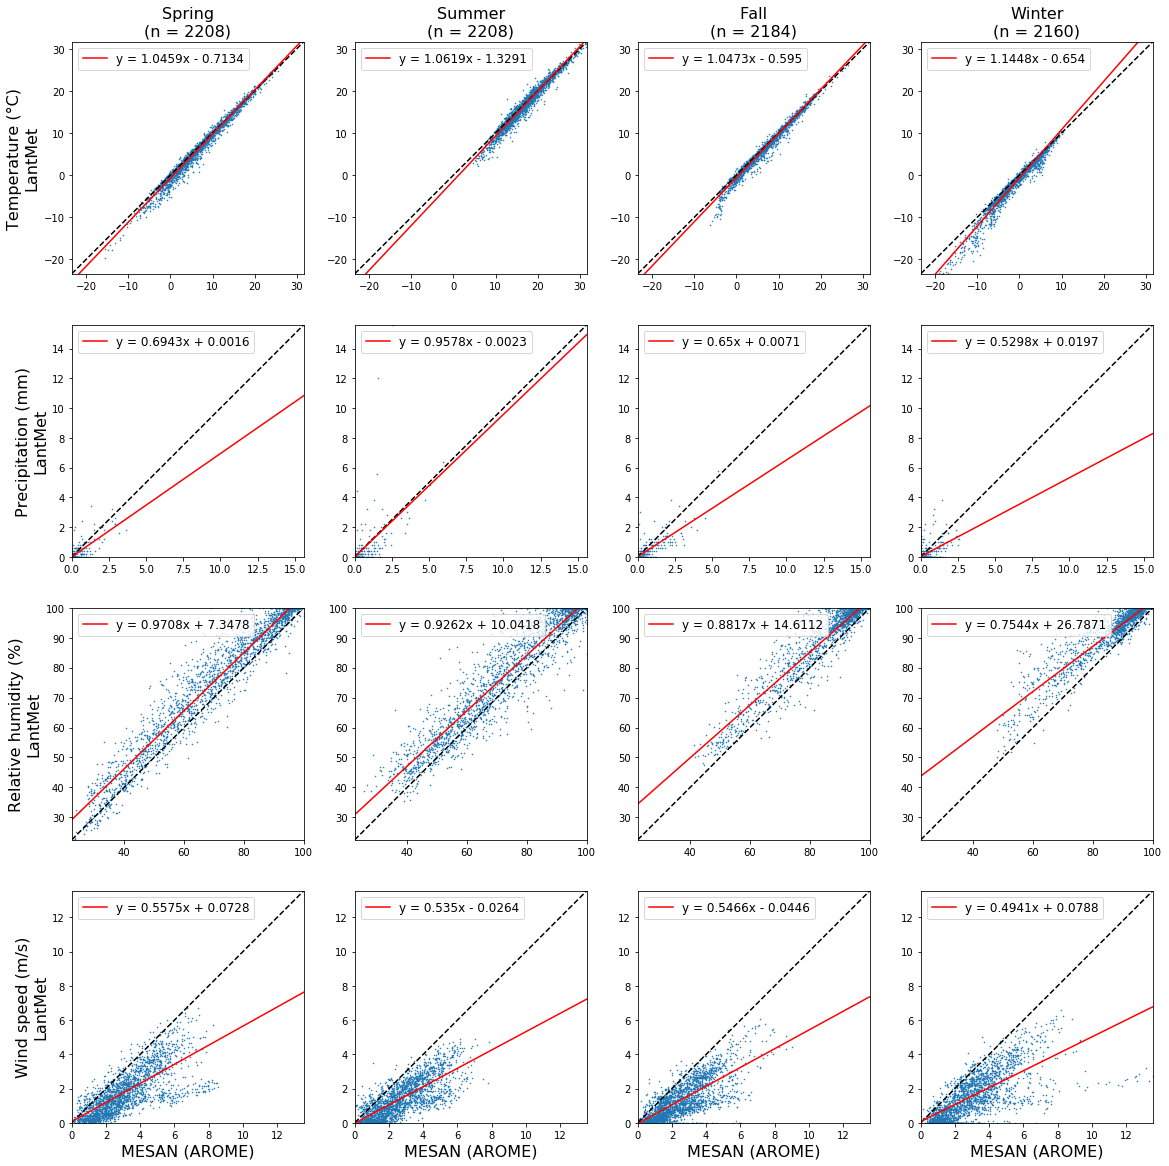

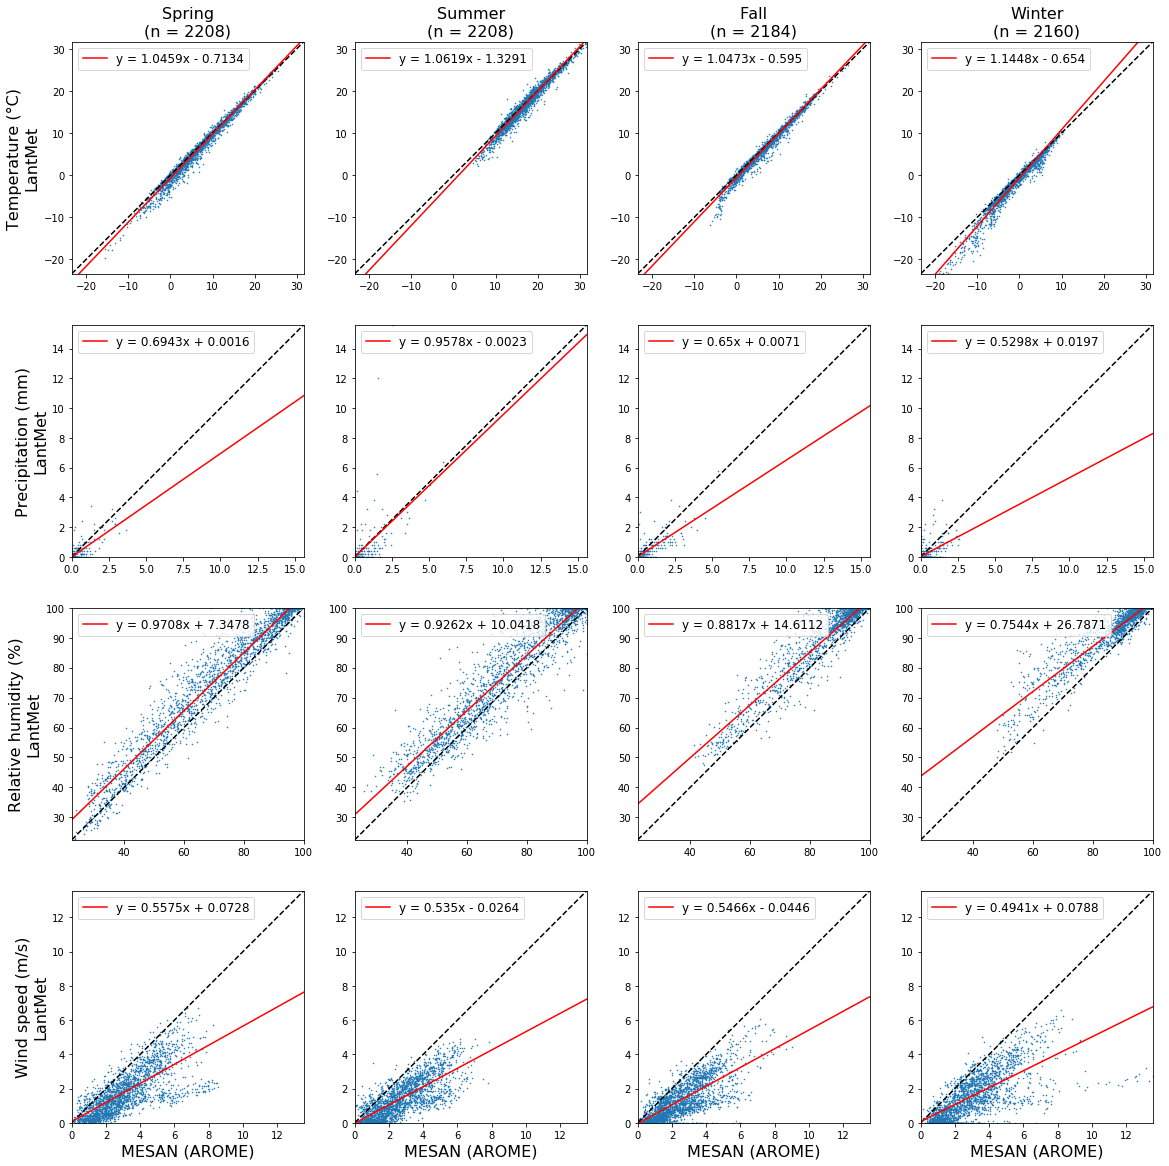

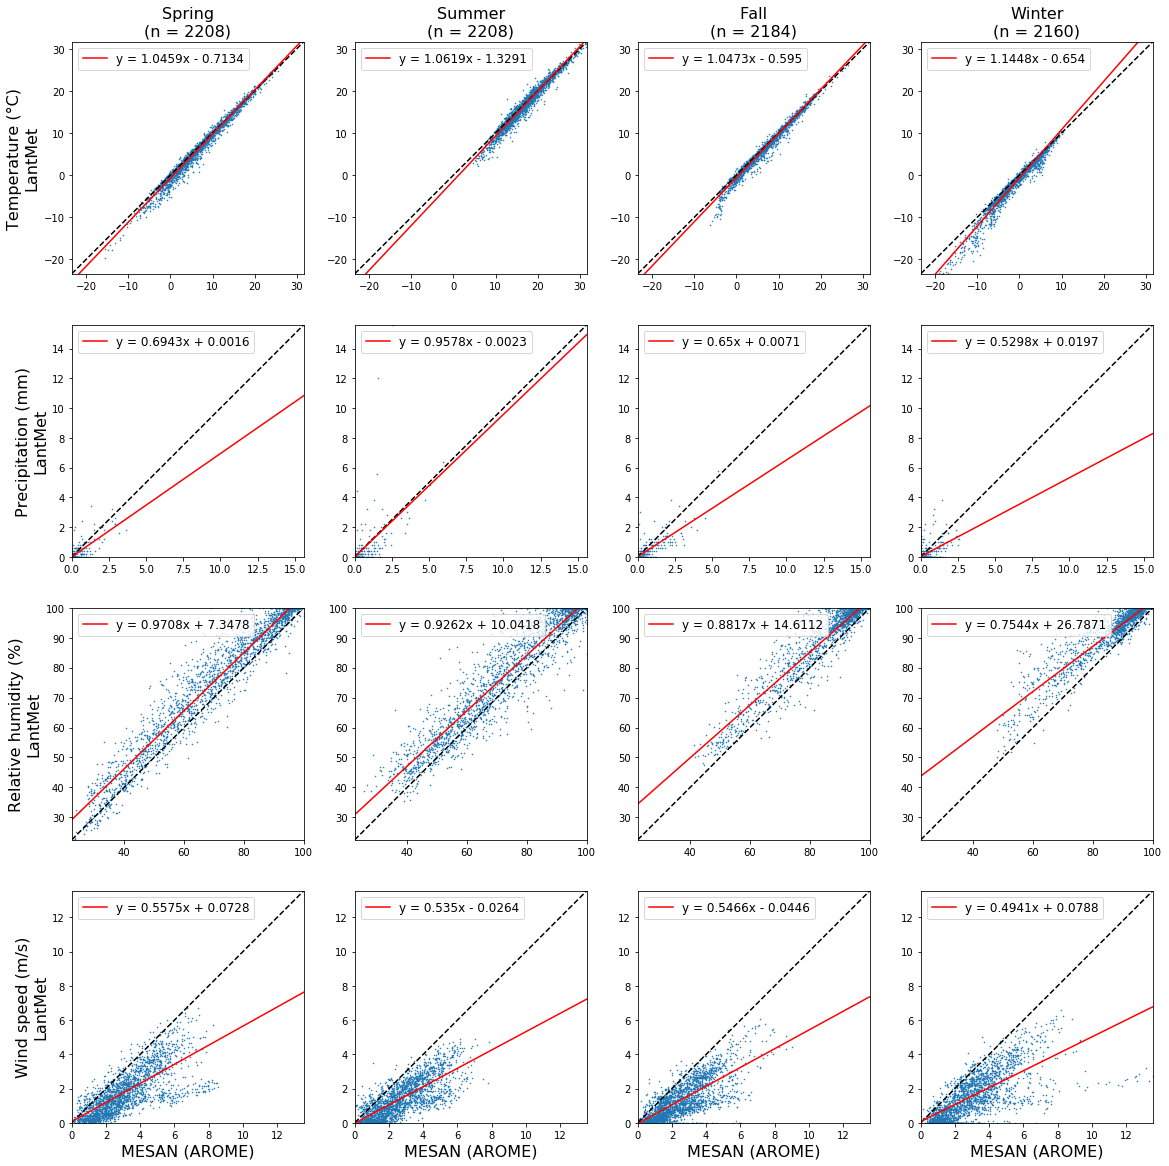

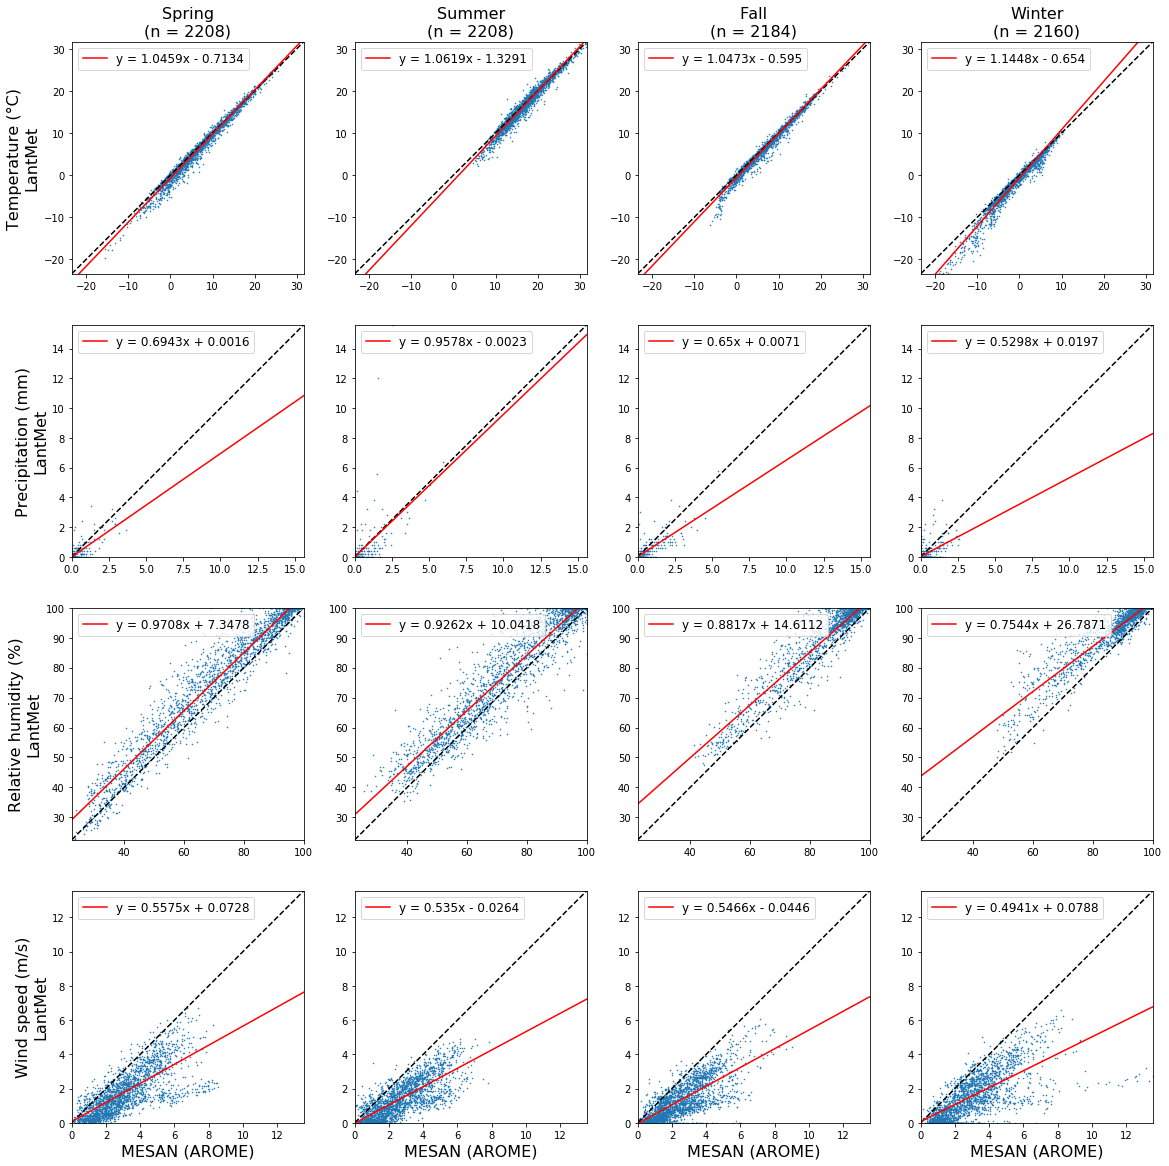

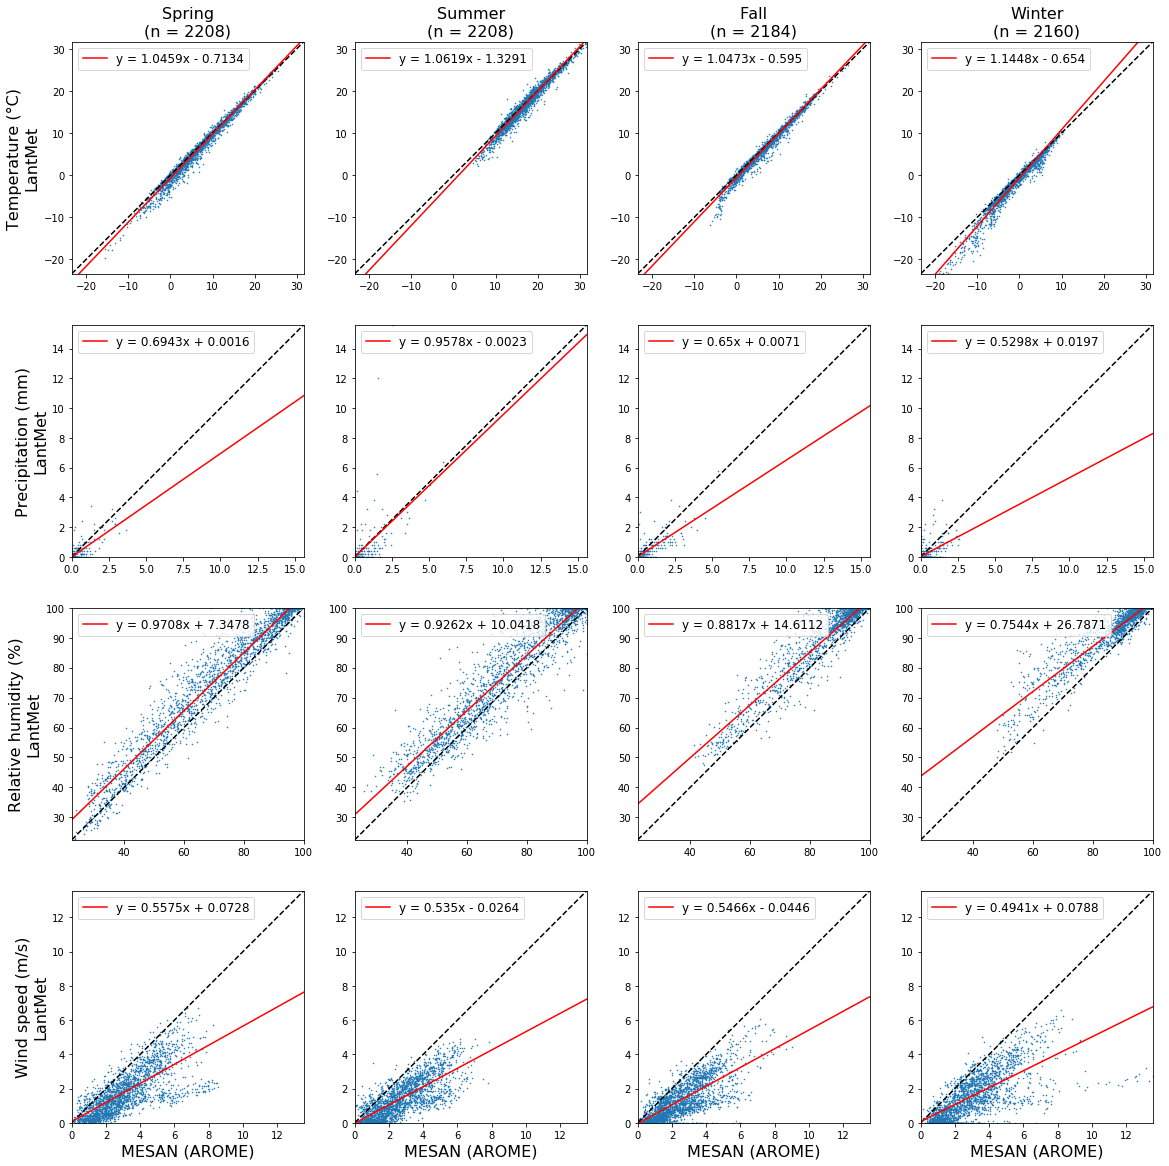

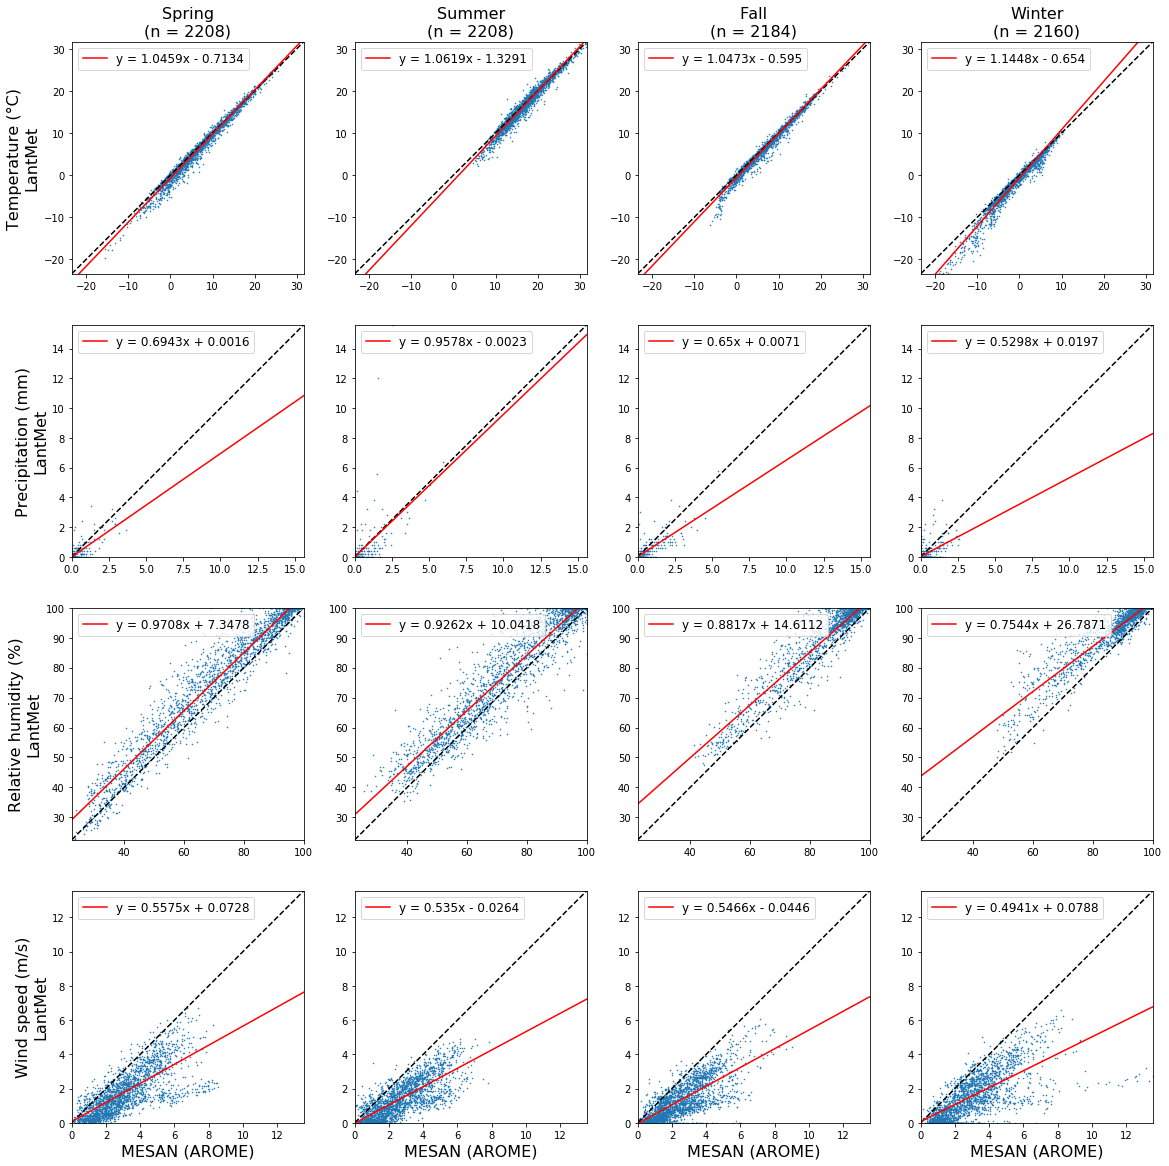

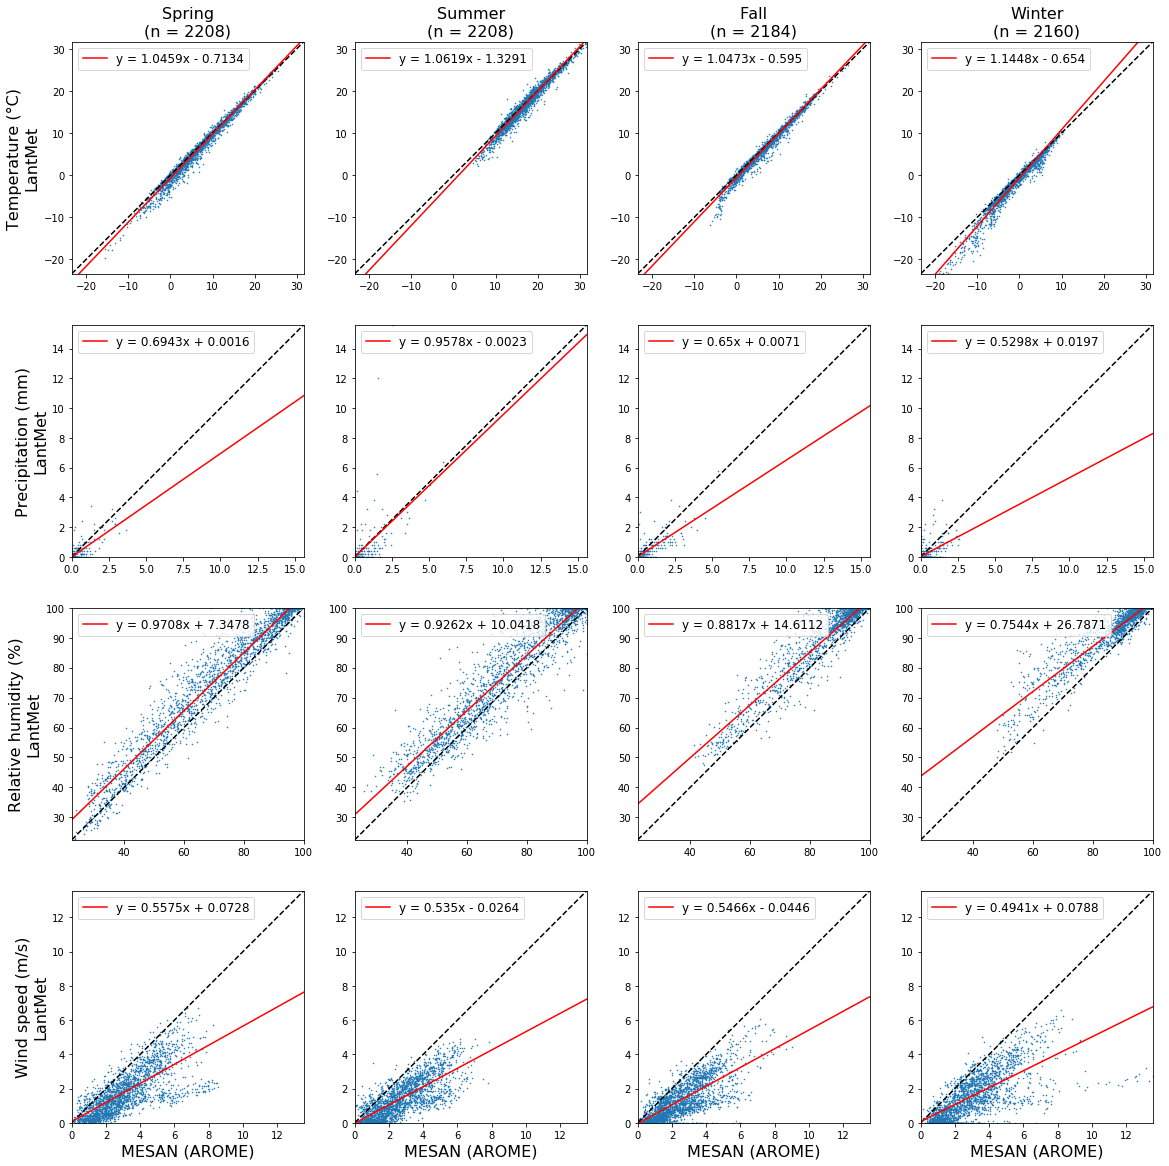

In [60]:
from METCOMP_utils import *
import numpy as np
import matplotlib.pyplot as plt

# === SETTINGS ======================================================================================
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}

# Should save figures?
should_save = False
images_dir = 'ScatterPlots/'

# y_labels.
param_title = {'t': 'Temperature (°C)\nLantMet', 'prec1h': 'Precipitation (mm)\nLantMet', 'r': 'Relative humidity (%)\nLantMet', 'ws': 'Wind speed (m/s)\nLantMet'}

# Seasons.
seasons = {'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Fall': [9, 10, 11], 'Winter': [12, 1, 2]}

# Time interval.
start_date = datetime.date(2017, 3, 1)
end_date = datetime.date(2020, 2, 29)

# Stations.
stations =  ['40013', '40010', '25754', '40003', '24768', '40005', '23470', '25786', '24856', '23658', '40004', '23659', '25652', '20949', '40145', '40007', '40143', '22234']
# ===================================================================================================



# Loop over all stations.
for station in stations:
    
    # Create fig and axis objects.
    fig, axs = plt.subplots(len(param_dict), len(seasons), figsize=(16, 16))
    fig.tight_layout(pad = 2)
    
    print(f'Working on station {station}')
    
    # Split into seasonal dataframes.
    MESAN_season = {}
    LANTMET_season = {}
    MESAN_months = divide_months(MESAN_data[station])
    LANTMET_months = divide_months(LANTMET_data[station])
    for season in seasons:
        # Init dict.
        MESAN_season[season] = None
        LANTMET_season[season] = None
    for season in seasons:
        for month in seasons[season]:
            # Build seasonal dataframes.
            MESAN_season[season] = pd.concat([MESAN_season[season], MESAN_months[month]], axis=0, ignore_index = True)
            LANTMET_season[season] = pd.concat([LANTMET_season[season], LANTMET_months[month]], axis=0, ignore_index = True)
        # Scale Humidity to [0, 100]
        MESAN_season[season]['r'] = MESAN_season[season]['r']*100
        LANTMET_season[season][param_dict['r']] = LANTMET_season[season][param_dict['r']]*100
    
    row = 0
    for param in param_dict:
        col = 0
        
        # Find limits.
        lims = []
        for season in seasons:
            lims.append(max(MESAN_season[season][param]))
            lims.append(min(MESAN_season[season][param]))
            lims.append(max(LANTMET_season[season][param_dict[param]]))
            lims.append(min(LANTMET_season[season][param_dict[param]]))
        lims = np.array([min(lims), max(lims)])
        
        for season in seasons:
            
            # Scatter datapoints.
            axs[row, col].scatter(MESAN_season[season][param], LANTMET_season[season][param_dict[param]], c='#1f77b4', s=0.3, label = None)
            
            # Get linear fit.
            k, m = np.polyfit(MESAN_season[season][param], LANTMET_season[season][param_dict[param]], 1) 
            
            # Plot linear regression.
            axs[row, col].plot(lims, lims, 'k--')
            if m < 0:
                label = f'y = {round(k, 4)}x - {abs(round(m, 4))}'
            else:
                label = f'y = {round(k, 4)}x + {abs(round(m, 4))}'
            axs[row, col].plot(lims, k*lims + m, 'r', label=label)
            
            # Set title, x- and y-labels.
            if row == 0:
                axs[row, col].set_title(f'{season}\n(n = {len(MESAN_season[season][param])})', fontsize=16)
            if row == len(param_dict) - 1:
                axs[row, col].set_xlabel('MESAN (AROME)', fontsize=16)
            if col == 0:
                axs[row, col].set_ylabel(param_title[param], fontsize=16)
            
            # Set legend with linear regression.
            axs[row, col].legend(loc='upper left', prop={'size': 12})
            
            # Set limits and aspect.
            axs[row, col].set_xlim(lims)
            axs[row, col].set_ylim(lims)
            x0,x1 = axs[row, col].get_xlim()
            y0,y1 = axs[row, col].get_ylim()
            axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
            
            col += 1
        row += 1
    
    # If figures should be saved this statement will be executed.
    if should_save:
        if not os.path.exists(images_dir):
            os.mkdir(images_dir)
        fig.savefig(f'{images_dir}{station}.png', bbox_inches='tight')
        
